In [29]:
from __future__ import print_function

from glob       import glob
from time       import time
import os
import sys
import numpy  as np
import tables as tb
import pandas as pd
import invisible_cities.reco.tbl_functions as tbl

from invisible_cities.cities.base_cities               import DetectorResponseCity
from invisible_cities.core.configure                   import configure, \
     print_configuration, \
      read_config_file
from invisible_cities.core.detector_response_functions import HPXeEL,  \
     gather_montecarlo_hits, \
     generate_ionization_electrons, \
     diffuse_electrons, \
     distribute_gain, \
     distribute_photons, \
     compute_photon_emmission_boundaries, \
     SiPM_response
from invisible_cities.core.detector_geometry_functions import TrackingPlaneBox, \
     MiniTrackingPlaneBox, determine_hrb_size
from invisible_cities.core.system_of_units_c           import units

In [30]:
from anastasia_plots import plot_nexus_event_hits, plot_box, plot_SiPM_map, scatter_particles_in_time_bin
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [31]:
f = os.path.join(os.environ['IC_DATA'], 'anastasia/nexus/se_1M_v0_08_07/hdf5_NEXT_NEW_se_1M_v0_08_07_0.h5')

### Configure

In [32]:
hpxe = HPXeEL(EP      =   3.5  * units.kilovolt / (units.cm * units.bar),
              dV      =   1.0  * units.mm/units.mus,
              P       =  15    * units.bar,
              d       =   5    * units.mm,
              t       =   5    * units.mm,
              t_el    =   2    * units.mus,
              L       = 530    * units.mm,
              Ws      =  24    * units.eV,
              Wi      =  16    * units.eV,
              ie_fano =   0.15           ,
              g_fano  =   0.1            ,
              diff_xy =  10    * units.mm/np.sqrt(units.m),
              diff_z  =   3    * units.mm/np.sqrt(units.m),
              rf      =   1)

tpbox = TrackingPlaneBox(x_min = -235 * units.mm,
                         x_max =  235 * units.mm,
                         y_min = -235 * units.mm,
                         y_max =  235 * units.mm,
                         z_min =    0 * units.mus,
                         z_max =  530 * units.mus,
                         x_pitch = 10 * units.mm,
                         y_pitch = 10 * units.mm,
                         z_pitch =  2 * units.mus)

NEVENTS = 1

hrb = MiniTrackingPlaneBox(tpbox)

#### Gather Hits from an input file

In [33]:
hits_f = gather_montecarlo_hits(f) 

In [34]:
print(type(hits_f))
print('This dict contains all the hits for all the events in this file')
print('Maps: event_index ---> np array of hits in this event')
print('')
print('One hit from one event looks like this:')
print(hits_f[2][0])
print('')
print('where,')
print('[   x coord,          y coord,          z coord,          energy    ]')

<class 'dict'>
This dict contains all the hits for all the events in this file
Maps: event_index ---> np array of hits in this event

One hit from one event looks like this:
[  5.77157784e+01   5.94437599e+01   1.36943451e+02   4.92307637e-03]

where,
[   x coord,          y coord,          z coord,          energy    ]


#### Run anastasia over just one event

In [35]:
evt = 2 
hits_ev = hits_f[evt]

A quick look at the the hits in this one event

Anastasia drifts all the electrons produced at all of these 
little blue dots to the EL and computes and records the SiPM response


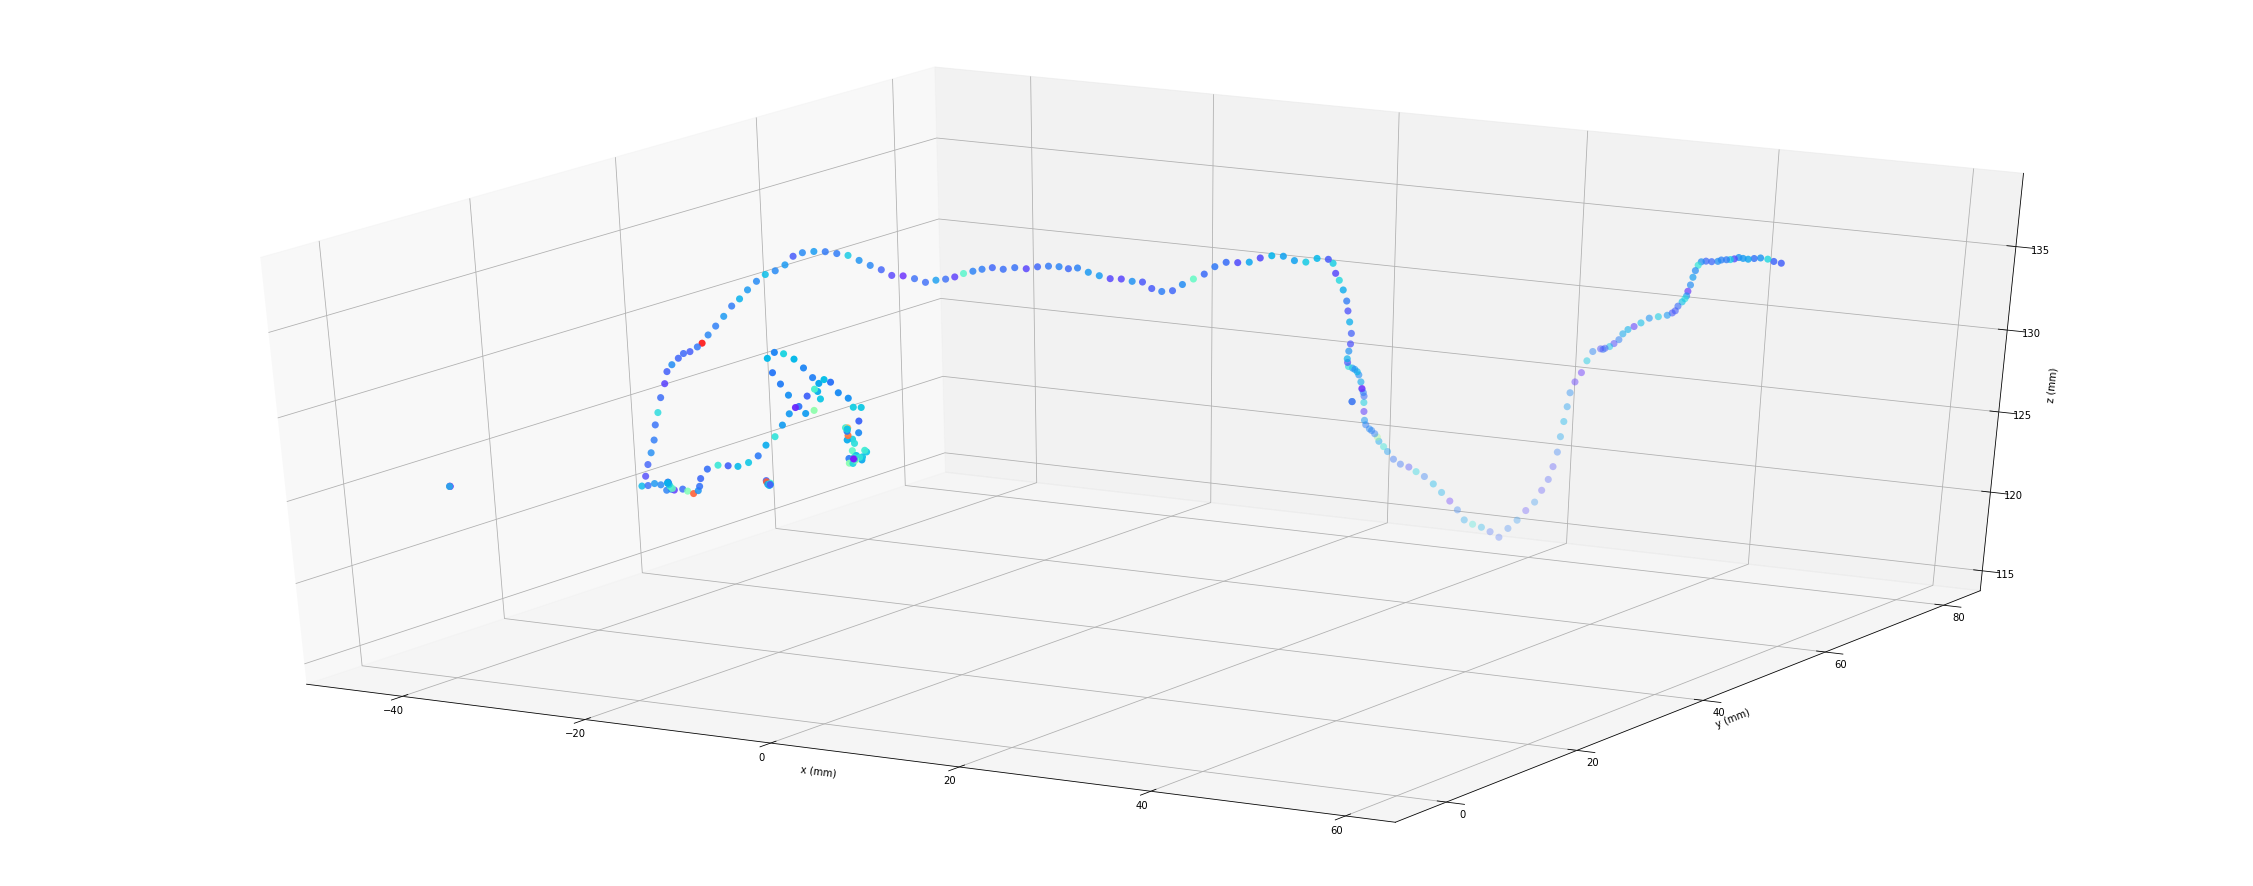

In [36]:
plot_nexus_event_hits(hits_ev)
print('Anastasia drifts all the electrons produced at all of these ')
print('little blue dots to the EL and computes and records the SiPM response')

Generate the ionization electrons produced by each hit in this event

In [37]:
electrons_ev = generate_ionization_electrons(hits_ev, hpxe)

In [38]:
print('electrons_ev is a dict containing all the ionization electrons produced by all the hits in this event')
print('Maps: hit_index ---> np array of ionization electrons from this hit')
s_hit      = 0 # define a sample hit
s_electron = 0 # and a sample electron
print('some sample e-: ')
print(electrons_ev[s_hit][s_electron:s_electron + 3])
print('where,')
print(' [   x coords,      y coords,      z coords   ]')

electrons_ev is a dict containing all the ionization electrons produced by all the hits in this event
Maps: hit_index ---> np array of ionization electrons from this hit
some sample e-: 
[[  57.71577835   59.44375992  136.94345093]
 [  57.71577835   59.44375992  136.94345093]
 [  57.71577835   59.44375992  136.94345093]]
where,
 [   x coords,      y coords,      z coords   ]


As you can see the sample e-, all from the same hit, have the same coordinates as the hit (check above). They are given the same initial starting position as the hit, they have not yet diffused to the EL. 

The only thing `generate_ionization_electrons` does, is produce the number of ionization electrons we expect to be produced by a hit. This number is proportional to the hit's energy.

#### Anastasia has by now
gathered all the ionization e- produced by all the hits in one event. At this point, `anastasia.run()` enters another loop that looks like this:

`for hit, electrons_h in electrons_ev.items()`

By dealing with ionization electrons from different hits separately, anastasia is able to decrease computational complexity because:

Ionization e- from a single hit will arrive to the EL relatively close together (in x, y, and time) even with diffusion, so the since photons produced as these e- cross the EL should provoke responses only in small subsection of the tracking plane box in x, y, and time. As we continue to follow anastasia hopefully this will become very clear. 

So, for now, we will deal only with ionization electrons produced by a single hit.

In [39]:
electrons_h = electrons_ev[s_hit]

A quick look inside `electrons_h`

In [40]:
print('type     : ', type(electrons_h))
print('shape    : ', electrons_h.shape)
print('sample_e-: ', electrons_h[s_electron])
print('and notice this is the same e- as above')

type     :  <class 'numpy.ndarray'>
shape    :  (308, 3)
sample_e-:  [  57.71577835   59.44375992  136.94345093]
and notice this is the same e- as above


#### Now Anastasia diffuses the ionization e- from the hit to the EL

In [41]:
electrons_h = diffuse_electrons(electrons_h, hpxe)

In [42]:
print(' [       x         ,       y        ,    time       ]')
print('')
print(electrons_h[s_electron: s_electron + 3])
print('(z=time in ns b/c of system of units)')

 [       x         ,       y        ,    time       ]

[[  5.70002174e+01   5.62407570e+01   1.37185469e+05]
 [  5.64599571e+01   6.28281326e+01   1.37325734e+05]
 [  5.08284912e+01   5.60401611e+01   1.37058156e+05]]
(z=time in ns b/c of system of units)


In [43]:
print('We can go back (more or less) to the hit coords by multiplying')
print('the time of arrival to the EL by the drift velocity: ')
print(' [       x      ,     y       ,      z     ]')
print('')
EEs = np.copy(electrons_h)
EEs[:,2] *= hpxe.dV
print(EEs[s_electron: s_electron + 3])

We can go back (more or less) to the hit coords by multiplying
the time of arrival to the EL by the drift velocity: 
 [       x      ,     y       ,      z     ]

[[  57.00021744   56.24075699  137.18547058]
 [  56.45995712   62.82813263  137.32574463]
 [  50.82849121   56.04016113  137.0581665 ]]


#### determine_hrb_size
After diffusing the electrons from the hit to the EL, Anastasia determines the size of the box of SiPMs that are expected to respond to the hit within nsig.

note:    
`sig_xy == hpxe.diff_xy * np.sqrt(hits_ev[s_hit, 2])`    
`sig_z  == hpxe.diff_z  * np.sqrt(hits_ev[s_hit, 2])`    
and `nsig` is the (approximate) number of sigmas Anastasia ensures fall within the hit response box.

a glimpse at how it works with standard diffusion and pitch

In [44]:
print('hit resposne box (x_dim, y_dim, z_dim)')
print('Increasing nsig... ')
print(determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=0))
print(determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=1))
print(determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=2))
print(determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=3))
print(determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=4))
print(determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=12))
print('Increasing drift distance...')
print(determine_hrb_size(0  *units.mm, hpxe, tpbox, nsig=3))
print(determine_hrb_size(100*units.mm, hpxe, tpbox, nsig=3))
print(determine_hrb_size(200*units.mm, hpxe, tpbox, nsig=3))
print(determine_hrb_size(300*units.mm, hpxe, tpbox, nsig=3))
print(determine_hrb_size(400*units.mm, hpxe, tpbox, nsig=3))
print(determine_hrb_size(500*units.mm, hpxe, tpbox, nsig=3))

hit resposne box (x_dim, y_dim, z_dim)
Increasing nsig... 
(4, 4, 1)
(5, 5, 3)
(6, 6, 4)
(7, 7, 5)
(7, 7, 6)
(13, 13, 15)
Increasing drift distance...
(4, 4, 1)
(6, 6, 4)
(7, 7, 6)
(8, 8, 6)
(8, 8, 7)
(9, 9, 8)


So, Anastasia gets the size of the hrb, and then creates an hrb of the determined size around where the electrons from the hit are expected to reach the EL.

In [45]:
hrb_shape = determine_hrb_size(hits_ev[s_hit, 2], hpxe, tpbox, nsig=2)
hit_at_el     = hits_ev[s_hit, :3]
hit_at_el[2] /= hpxe.dV
hrb.center(hit_at_el, hrb_shape)

#### A centered hrb
The hrb has found its absolute position around `s_hit`. Below are some plots to illustrate exactly what this means. Anastasia will compute responses for SiPMs within the dotted box.

One thing worth noticing is that (as long as nsig is not too small) the rectangle of responsive SiPMs in each z extends beyond where the cloud of diffused electrons reaches the EL. This is because SiPMs have a nonzero probability of detecting the photons produced by these e- from up to about 20mm away in the x, y plane. 

hrb shape = (6, 6, 4)


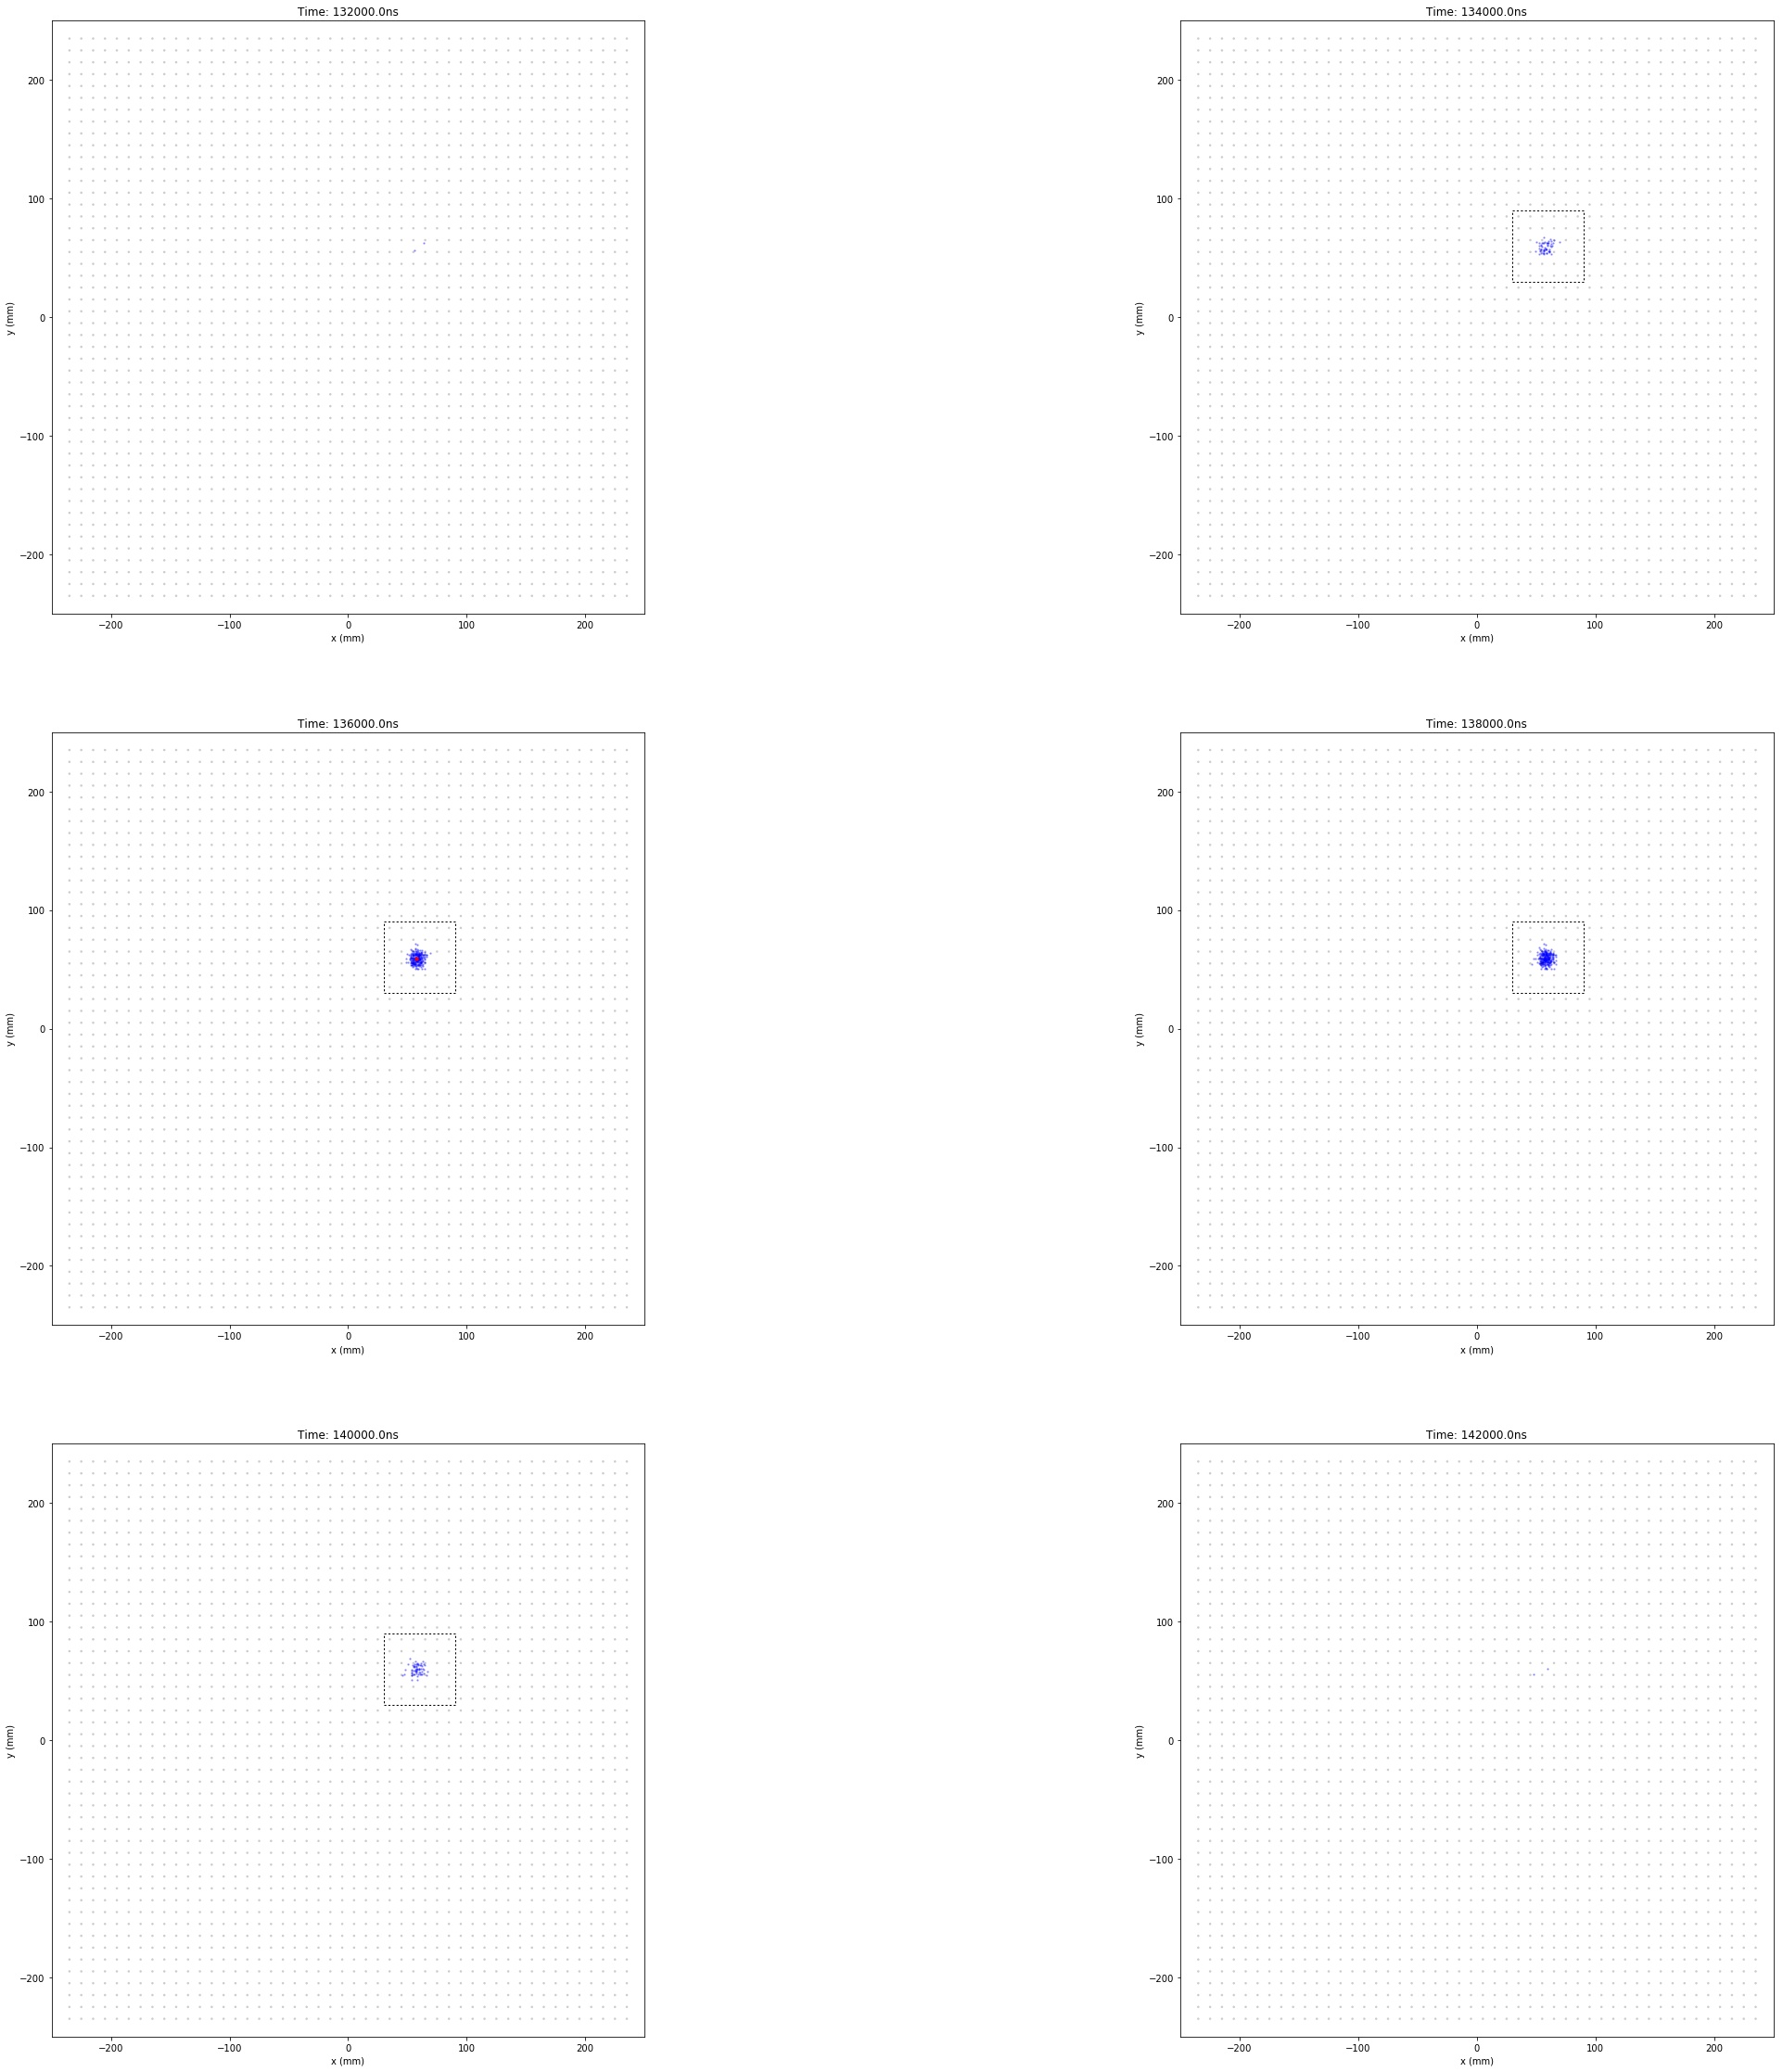

In [46]:
print('hrb shape = ' + str(hrb.shape))
fig = plt.figure();
fig.set_figheight(40)
fig.set_figwidth (40)
Z = list(hrb.z_pos)

# also plot a time bin before and after if such a time bin exists.
if Z[ 0] - hrb.z_pitch >= tpbox.z_min: Z = [Z[0] - hrb.z_pitch] + Z
if Z[-1] + hrb.z_pitch <= tpbox.z_max: Z.append(Z[-1] + hrb.z_pitch)

for i, z in enumerate(Z):
    ax1 = fig.add_subplot(int(np.ceil(len(Z) / 2.0)), 2, i+1, aspect='equal')
    ax1.axis([-250, 250, -250, 250])
    m = np.where(tpbox.z_pos == z)[0] # corresponding time bin in resp_ev 
    if z in hrb.z_pos: plot_box(ax1, hrb) # only plot hrb for time bins it covers
    plot_SiPM_map(ax1, tpbox, hrb.resp_ev[:, :, m])
    scatter_particles_in_time_bin(electrons_h, z, hrb.z_pitch, hpxe.t_el, c='b', s= 2, a=.3) # plot electrons
    scatter_particles_in_time_bin([hit_at_el], z, hrb.z_pitch,         0, c='r', s=10, a=1 ) # plot center of hit   
    plt.title('Time: ' + str(z) + 'ns')
plt.show()


In plots above a little blue dot appears if the electron (represented by the little blue dot) is producing photons during that time bin. 

Unfortunately, Anastasia needs to know not only if each e- is producing photons during each time bin, but also how many photons are being produced by each e- in each time bin. This turns out to be a more complicated question. The electrons arrive to the EL all at different times that do not need to align neatly with the beginning or end of a new time bin. Then, the electrons cross the el  for a period of time t_el. t_el might correspond to time bin 2.3 -- > time bin 4.8

#### Anastasia calls `distribute_gain`  to sort out this mess. 

In [47]:
FG = distribute_gain(electrons_h, hpxe, hrb)
print('Type : ' + str(type(FG)))
print('Shape: ' + str(FG.shape))
print('FG for first 10 electrons:')
print(FG[s_electron: s_electron+10])
print('')
print('FG[e-, timebin] = (time e- was producing light during timebin / t_el)')

Type : <class 'numpy.ndarray'>
Shape: (308, 4)
FG for first 10 electrons:
[[ 0.          0.40726566  0.5927344   0.        ]
 [ 0.          0.33713281  0.66286719  0.        ]
 [ 0.          0.47092187  0.52907813  0.        ]
 [ 0.6251719   0.          0.          0.        ]
 [ 0.          0.40960157  0.59039843  0.        ]
 [ 0.          0.8988359   0.10116407  0.        ]
 [ 0.          0.18188286  0.8181172   0.        ]
 [ 0.          0.70728123  0.29271874  0.        ]
 [ 0.07314062  0.          0.          0.        ]
 [ 0.23478907  0.          0.          0.        ]]

FG[e-, timebin] = (time e- was producing light during timebin / t_el)


#### `distribute_gain`  has given us...  
a np array of `shape == len(electrons_h), len(hrb.z_pos)` containing the fraction of gain produced by each electron in each time bin in hrb. This is a good opportunity to check to see the fraction of light produced by electrons_h within are hrb z-window.

In [48]:
number_of_electrons_in_hit = float(len(FG))
print(FG.sum() / number_of_electrons_in_hit)

0.862047467913


#### Anastasia then calculates the number of photons produced in each time bin

In [49]:
print('photons[i,j] == FG[i,j] * k + some noise')
print('')
photons = distribute_photons(FG, hpxe)
print('Type : ' + str(type(photons)))
print('Shape: ' + str(photons.shape))
print('photons from first 10 electrons:')
print(photons[s_electron: s_electron+10])

photons[i,j] == FG[i,j] * k + some noise

Type : <class 'numpy.ndarray'>
Shape: (308, 4)
photons from first 10 electrons:
[[    0.  1136.  1675.     0.]
 [    0.   943.  1849.     0.]
 [    0.  1333.  1477.     0.]
 [ 1768.     0.     0.     0.]
 [    0.  1149.  1671.     0.]
 [    0.  2531.   286.     0.]
 [    0.   514.  2316.     0.]
 [    0.  2001.   815.     0.]
 [  199.     0.     0.     0.]
 [  653.     0.     0.     0.]]


#### z integration boundaries
Anastasia's currently uses a function to calculate SiPM response that requires the z distance from the electron producing photons to the SiPM plane. And, since the function calculates the SiPM response one time bin at a time, it requires the z distance of the electron to the SiPM plane at the start of the time bin and at the end of the time bin.

In [50]:
IB = compute_photon_emmission_boundaries(FG, hpxe)
print('Type : ' + str(type(IB)))
print('Shape: ' + str(IB.shape))
print('photons from first 3 electrons:')
print(IB[s_electron: s_electron+3])
print('')
print('IB[-e, timebin] = [e- start distance to SiPM plane, e- end distance to SiPM plane]')

Type : <class 'numpy.ndarray'>
Shape: (308, 4, 2)
photons from first 3 electrons:
[[[ 10.          10.        ]
  [ 10.           7.96367168]
  [  7.96367168   5.        ]
  [  5.           5.        ]]

 [[ 10.          10.        ]
  [ 10.           8.31433582]
  [  8.31433582   5.        ]
  [  5.           5.        ]]

 [[ 10.          10.        ]
  [ 10.           7.64539051]
  [  7.64539051   5.        ]
  [  5.           5.        ]]]

IB[-e, timebin] = [e- start distance to SiPM plane, e- end distance to SiPM plane]


#### Finally Anastasia is ready to compute the SiPM responses in hrb

In [51]:
hrb.resp_h = SiPM_response(electrons_h, photons, IB, hrb)
print('Type : ' + str(type(hrb.resp_h)))
print('Shape: ' + str(hrb.resp_h.shape))
print('Max sipm response: '+ str(hrb.resp_h.max()) + ' pes')

Type : <class 'numpy.ndarray'>
Shape: (6, 6, 4)
Max sipm response: 848.634 pes


The hrb waveform


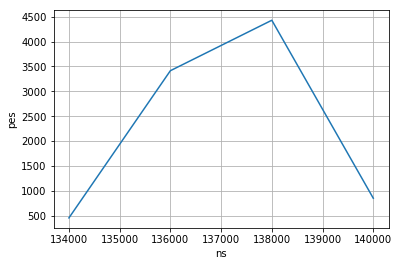

In [52]:
print('The hrb waveform')
plt.plot(hrb.z_pos, hrb.resp_h.sum(axis=0).sum(axis=0))
plt.grid(True)
plt.xlabel('ns')
plt.ylabel('pes')
plt.show()


hrb shape = (6, 6, 4)


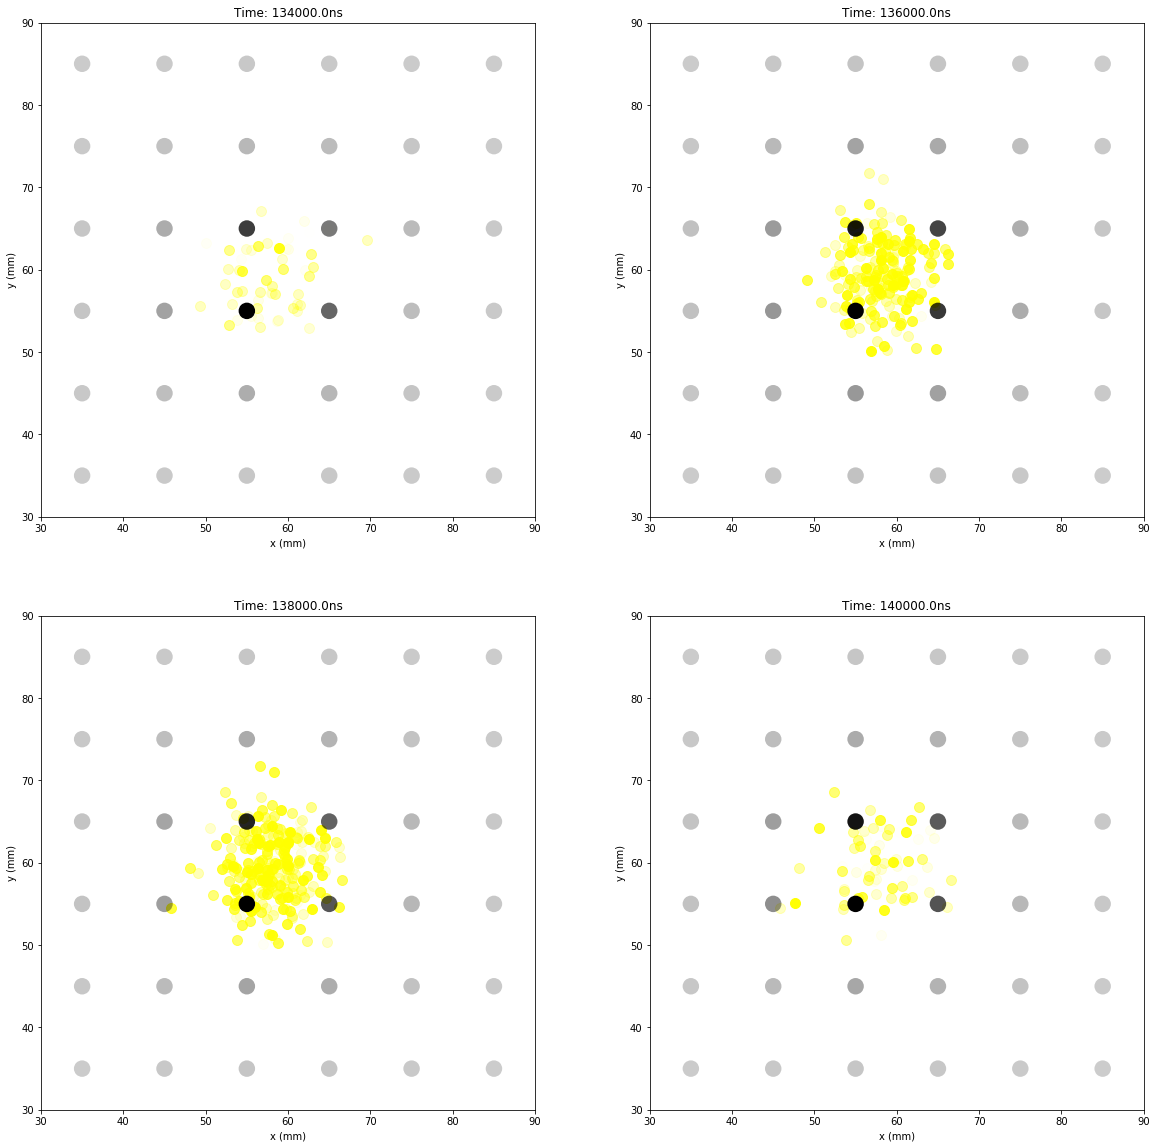

In [53]:
print('hrb shape = ' + str(hrb.shape))
fig = plt.figure();
fig.set_figheight(20)
fig.set_figwidth (20)
for i, z in enumerate(hrb.z_pos):
    ax1 = fig.add_subplot(int(np.ceil(len(hrb.z_pos) / 2.0)), 2, i+1, aspect='equal')
    
    ax1.axis([hrb.x_min - hrb.x_pitch / 2., 
              hrb.x_max + hrb.x_pitch / 2., 
              hrb.y_min - hrb.y_pitch / 2., 
              hrb.y_max + hrb.y_pitch / 2.])
    
    plot_SiPM_map(ax1, hrb, hrb.resp_h[:, :, i])
    scatter_particles_in_time_bin(electrons_h, z, hrb.z_pitch, hpxe.t_el, 
                                  magnitude=FG[:, i], c='yellow', s=100, a=1) # plot electrons
    plt.title('Time: ' + str(z) + 'ns')
    
#plt.show()

In [54]:
# add hit response to event response
hrb.add_hit_resp_to_event_resp()

-1

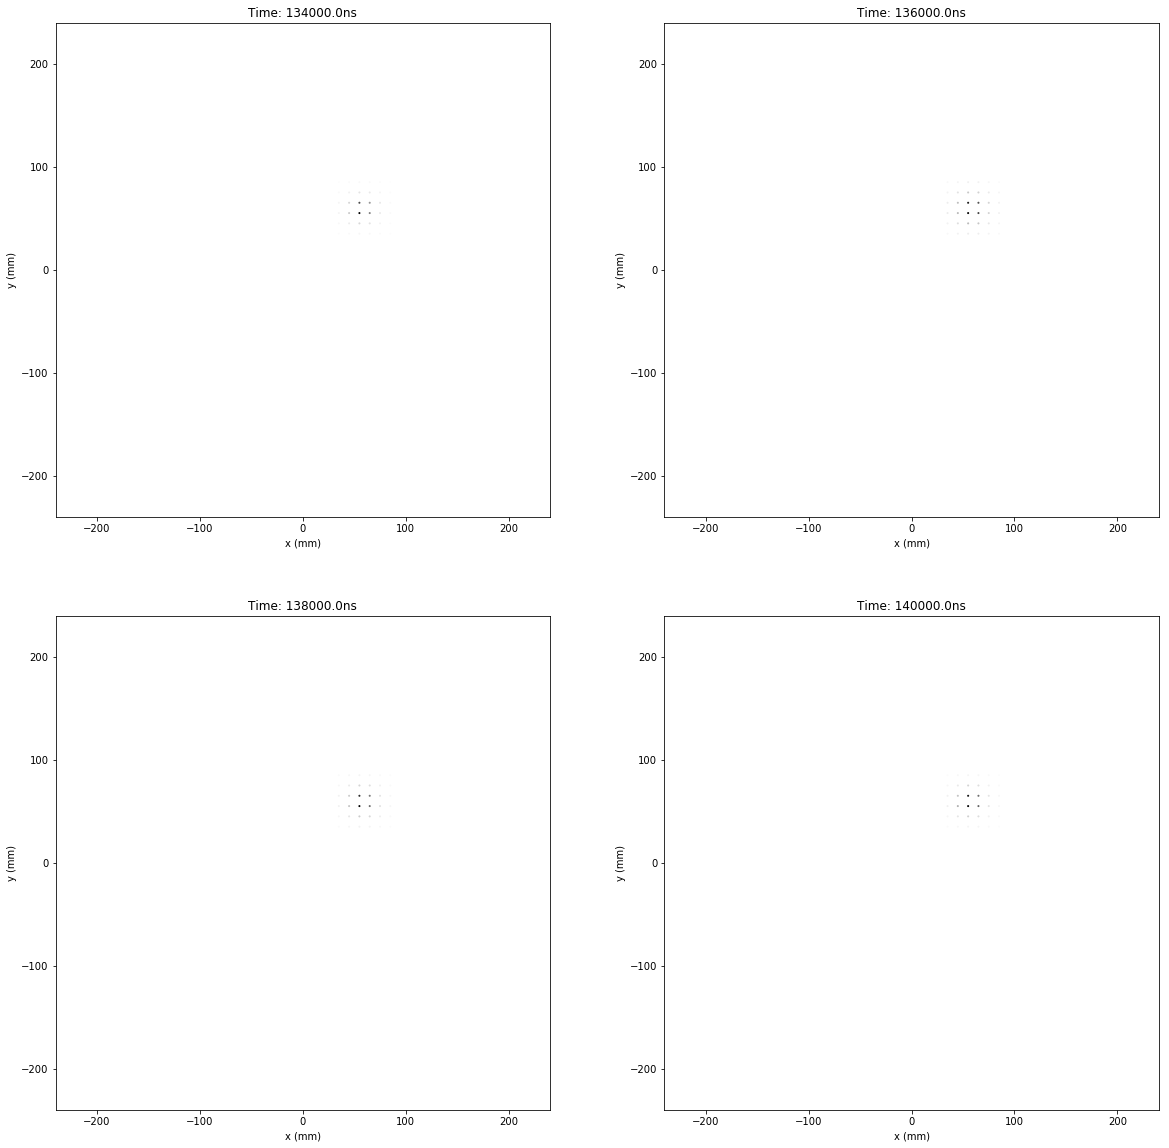

In [55]:
fig = plt.figure();
fig.set_figheight(20)
fig.set_figwidth (20)
for i, z in enumerate(hrb.z_pos):
    ax1 = fig.add_subplot(int(np.ceil(len(hrb.z_pos) / 2.0)), 2, i+1, aspect='equal')
    
    ax1.axis([tpbox.x_min - tpbox.x_pitch / 2., 
              tpbox.x_max + tpbox.x_pitch / 2., 
              tpbox.y_min - tpbox.y_pitch / 2., 
              tpbox.y_max + tpbox.y_pitch / 2.])
    m = np.where(tpbox.z_pos == z)[0] # corresponding time bin in resp_ev 
    plot_SiPM_map(ax1, tpbox, hrb.resp_ev[:, :, m], minc=0)

    plt.title('Time: ' + str(z) + 'ns')